In [3]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf


In [4]:
import sys
import os

# Add the scripts folder to the system path
scripts_path = os.path.abspath(os.path.join('..', 'scripts/python'))
sys.path.append(scripts_path)


In [5]:
# data_processing.ipynb

# Import necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import functions from utils.py
from utils import (
    AR,
    check_percentage_tashkeel,
    Clean_data,
    separate_token_with_diacritics,
    factor_shadda_tanwin,
    extract_rhyme_info,          
    get_verse_length_features,
    string_with_tashkeel_vectorizer,
    string_with_tashkeel_vectorizer_per_batch
)

# Configure visualization settings
%matplotlib inline
sns.set(style="whitegrid")


In [6]:
# Define paths
raw_data_path = '../data/raw/apcd/apcd_full.csv'  # Update if necessary
processed_output_dir = '../data/processed'

# Load raw data
print("Loading raw data...")
try:
    raw_df = pd.read_csv(raw_data_path, encoding='utf-8')
    print(f"Raw data loaded successfully with {len(raw_df)} records.")
except FileNotFoundError:
    print(f"Error: File not found at {raw_data_path}")


Loading raw data...
Raw data loaded successfully with 1831770 records.


In [7]:
# Preview raw data
raw_df.head()

,العصر,الشاعر,الديوان,القافية,البحر,الشطر الايسر,الشطر الايمن,البيت
0,قبل الإسلام,عمرو بنِ قُمَيئَة,الديوان الرئيسي,د,الطويل,وَأَن تَجمَعا شَملي وَتَنتَظِرا غَدا,خَليلَيَّ لا تَستَعجِلا أَن تَزَوَّدا,خَليلَيَّ لا تَستَعجِلا أَن تَزَوَّدا وَأَن...
1,قبل الإسلام,عمرو بنِ قُمَيئَة,الديوان الرئيسي,د,الطويل,وَلا سُرعَتي يَوماً بِسابِقَةِ الرَدى,فَما لَبَثٌ يَوماً بِسابِقٍ مَغنَمٍ,فَما لَبَثٌ يَوماً بِسابِقٍ مَغنَمٍ وَلا سُ...
2,قبل الإسلام,عمرو بنِ قُمَيئَة,الديوان الرئيسي,د,الطويل,وَتَستَوجِبا مَنّاً عَلَيَّ وَتُحمَدا,وَإِن تُنظِراني اليَومَ أَقضِ لُبانَةً,وَإِن تُنظِراني اليَومَ أَقضِ لُبانَةً وَتَ...
3,قبل الإسلام,عمرو بنِ قُمَيئَة,الديوان الرئيسي,د,الطويل,تُؤامِرُني سِرّاً لِأَصرِمَ مَرثَدا,لَعَمرُكَ ما نَفسٌ بِجِدٍ رَشيدَةٍ,لَعَمرُكَ ما نَفسٌ بِجِدٍ رَشيدَةٍ تُؤامِرُ...
4,قبل الإسلام,عمرو بنِ قُمَيئَة,الديوان الرئيسي,د,الطويل,وَأَفرَعَ في لَومي مِراراً وَأَصعَدا,وَإِن ظَهَرَت مِنهُ قَوارِصُ جَمَّةٌ,وَإِن ظَهَرَت مِنهُ قَوارِصُ جَمَّةٌ وَأَفر...


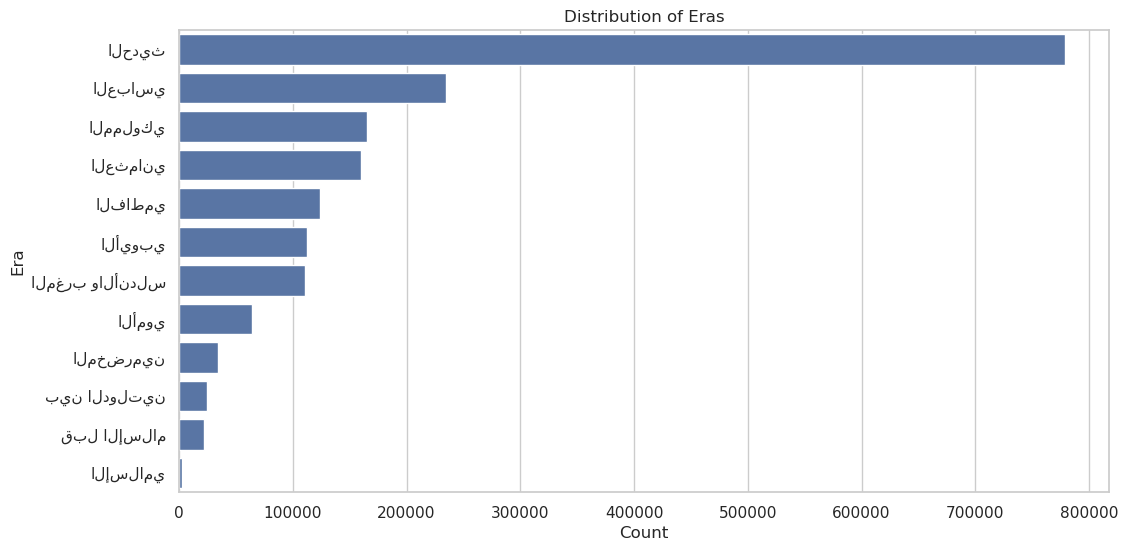

In [8]:
# Optional: Inspect the distribution of eras before filtering
plt.figure(figsize=(12, 6))
sns.countplot(y='العصر', data=raw_df, order=raw_df['العصر'].value_counts().index)
plt.title('Distribution of Eras')
plt.xlabel('Count')
plt.ylabel('Era')
plt.show()


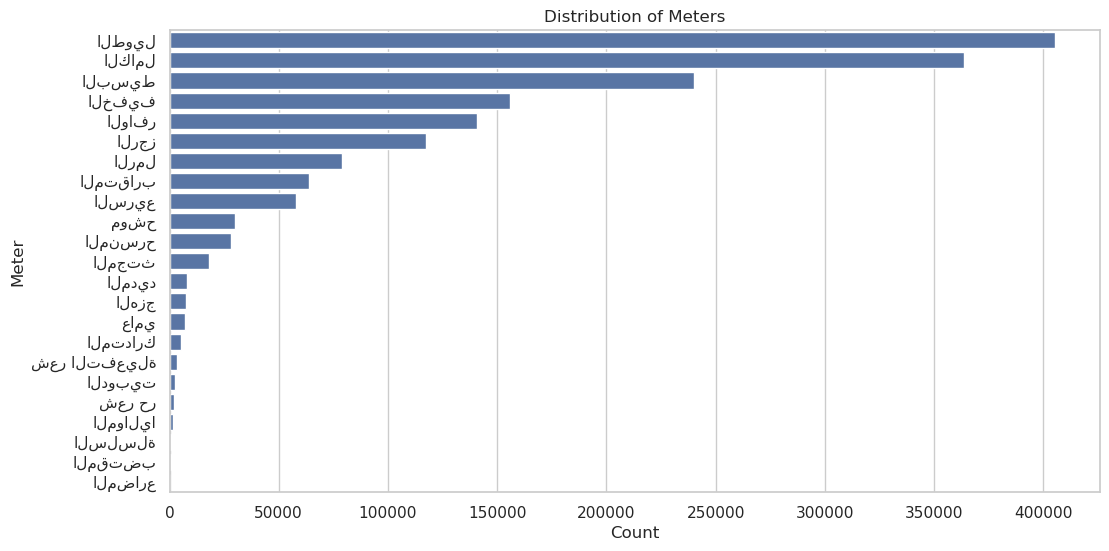

In [9]:
# Optional: Inspect the distribution of meters before filtering
plt.figure(figsize=(12, 6))
sns.countplot(y='البحر', data=raw_df, order=raw_df['البحر'].value_counts().index)
plt.title('Distribution of Meters')
plt.xlabel('Count')
plt.ylabel('Meter')
plt.show()


In [26]:
# Count the values for each Meter and sort them by count
meter_counts = raw_df['البحر'].value_counts()

# Print the values
print(meter_counts)


البحر
الطويل          405378
الكامل          363486
البسيط          239974
الخفيف          156049
الوافر          140560
الرجز           117572
الرمل            79015
المتقارب         63818
السريع           58084
موشح             30060
المنسرح          28357
المجتث           17884
المديد            7829
الهزج             7541
عامي              7074
المتدارك          5037
شعر التفعيلة      3232
الدوبيت           2713
شعر حر            2135
المواليا          1644
السلسلة            907
المقتضب            799
المضارع            288
Name: count, dtype: int64


In [10]:
# Optional: Set allowed eras and meters (adjust as needed)
allowed_eras = None  # e.g., ['العصر الجاهلي', 'العصر الأموي']
allowed_meters = None  # e.g., ['الطويل', 'الكامل']
# Apply optional era and meter filtering
if allowed_eras or allowed_meters:
    print("Applying era and/or meter filtering...")
    filtered_era_meter_df = raw_df.copy()
    if allowed_eras:
        filtered_era_meter_df = filtered_era_meter_df[filtered_era_meter_df['العصر'].isin(allowed_eras)]
        print(f"After era filtering: {len(filtered_era_meter_df)} records.")
    if allowed_meters:
        filtered_era_meter_df = filtered_era_meter_df[filtered_era_meter_df['البحر'].isin(allowed_meters)]
        print(f"After meter filtering: {len(filtered_era_meter_df)} records.")
else:
    filtered_era_meter_df = raw_df.copy()
    print("No era or meter filtering applied.")


No era or meter filtering applied.


In [11]:
# Add additional features: rhyme_info and verse_length_features
print("Extracting additional features: rhyme_info and verse_length_features...")
filtered_era_meter_df = extract_rhyme_info(filtered_era_meter_df)
filtered_era_meter_df = get_verse_length_features(filtered_era_meter_df)
print("Additional features extracted.")

Extracting additional features: rhyme_info and verse_length_features...
Additional features extracted.


In [13]:
# Apply diacritization filtering on 'البيت'
tashkeel_threshold = 0.4  # Adjust as needed
print(f"Applying diacritization filtering with threshold {tashkeel_threshold}...")
filtered_era_meter_df['passes_diacritization'] = filtered_era_meter_df['البيت'].apply(lambda x: check_percentage_tashkeel(x, threshold=tashkeel_threshold))
filtered_df = filtered_era_meter_df[filtered_era_meter_df['passes_diacritization']].copy()
print(f"Filtered dataset size: {len(filtered_df)}")


Applying diacritization filtering with threshold 0.4...
Filtered dataset size: 771424


In [14]:
# Optional: Inspect filtered dataset
filtered_df.head()

# Print full content of the first 5 rows for the column "البيت"
pd.set_option('display.max_colwidth', None)
print(filtered_df["البيت"].head())

0      خَليلَيَّ لا تَستَعجِلا أَن تَزَوَّدا    وَأَن تَجمَعا شَملي وَتَنتَظِرا غَدا
1       فَما لَبَثٌ يَوماً بِسابِقٍ مَغنَمٍ    وَلا سُرعَتي يَوماً بِسابِقَةِ الرَدى
2    وَإِن تُنظِراني اليَومَ أَقضِ لُبانَةً    وَتَستَوجِبا مَنّاً عَلَيَّ وَتُحمَدا
3          لَعَمرُكَ ما نَفسٌ بِجِدٍ رَشيدَةٍ    تُؤامِرُني سِرّاً لِأَصرِمَ مَرثَدا
4       وَإِن ظَهَرَت مِنهُ قَوارِصُ جَمَّةٌ    وَأَفرَعَ في لَومي مِراراً وَأَصعَدا
Name: البيت, dtype: object


In [30]:
# Select and rename relevant columns
processed_df = filtered_df[['البيت', 'البحر', 'العصر', 'الشاعر', 'القافية',
                            'rhyme_info', 'verse_length', 'avg_shatr_length']].rename(columns={
    'البيت': 'text',
    'البحر': 'meter',
    'العصر': 'era',
    'الشاعر': 'poet',
    'القافية': 'rhyme'
})
print("Selected and renamed relevant columns.")


Selected and renamed relevant columns.


In [31]:
# Clean the text data using Clean_data function
# Note: Adjust 'max_bayt_len' based on your dataset's characteristics
max_bayt_len = 1000
print("Cleaning the text data...")
processed_df = Clean_data(processed_df, max_bayt_len=max_bayt_len, verse_column_name='text')
print("Text data cleaned.")


Cleaning the text data...
Text data cleaned.


In [32]:
# Preview processed data
processed_df.head()


,text,meter,era,poet,rhyme,rhyme_info,verse_length,avg_shatr_length
0,خَليلَيْيَ لا تَستَعجِلا ءَن تَزَوْوَدا وَءَن تَجمَعا شَملي وَتَنتَظِرا غَدا,الطويل,قبل الإسلام,عمرو بنِ قُمَيئَة,د,None,73,36.5
1,فَما لَبَثُنْ يَومنْ بِسابِقِنْ مَغنَمِنْ وَلا سُرعَتي يَومنْ بِسابِقَةِ الرَدى,الطويل,قبل الإسلام,عمرو بنِ قُمَيئَة,د,None,72,36.0
2,وَءِن تُنظِراني اليَومَ ءَقضِ لُبانَتَنْ وَتَستَوجِبا مَنْننْ عَلَيْيَ وَتُحمَدا,الطويل,قبل الإسلام,عمرو بنِ قُمَيئَة,د,None,75,37.5
3,لَعَمرُكَ ما نَفسُنْ بِجِدِنْ رَشيدَتِنْ تُءامِرُني سِرْرنْ لِءَصرِمَ مَرثَدا,الطويل,قبل الإسلام,عمرو بنِ قُمَيئَة,د,None,69,34.5
4,وَءِن ظَهَرَت مِنهُ قَوارِصُ جَمْمَتُنْ وَءَفرَعَ في لَومي مِرارنْ وَءَصعَدا,الطويل,قبل الإسلام,عمرو بنِ قُمَيئَة,د,None,72,36.0


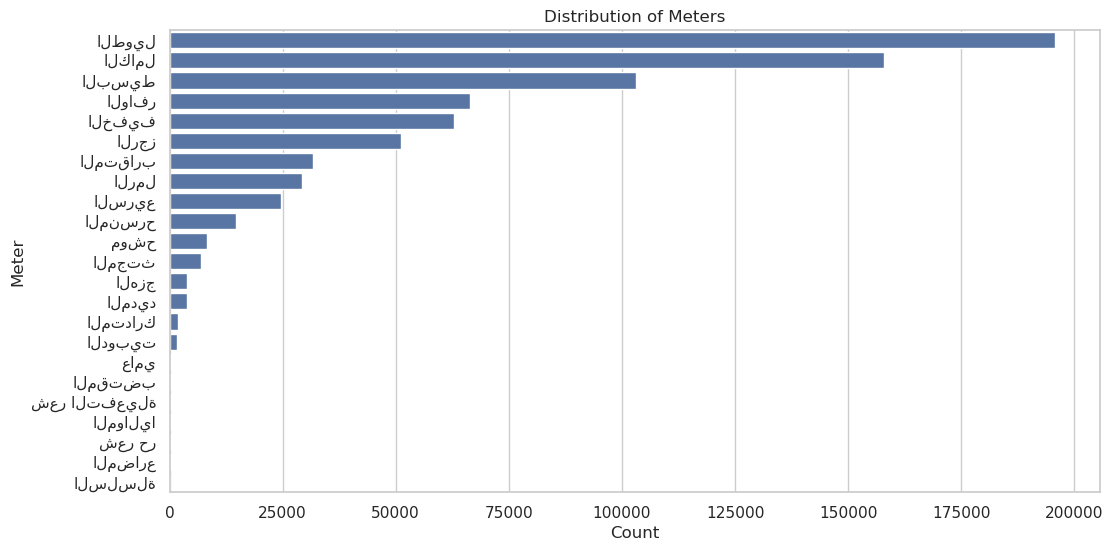

In [33]:
# Visualize distribution of meters
plt.figure(figsize=(12, 6))
sns.countplot(y='meter', data=processed_df, order=processed_df['meter'].value_counts().index)
plt.title('Distribution of Meters')
plt.xlabel('Count')
plt.ylabel('Meter')
plt.show()


In [34]:
# Count the values for each Meter and sort them by count
meter_counts_processed = processed_df['meter'].value_counts()

# Print the values
print(meter_counts_processed)


meter
الطويل          195750
الكامل          157991
البسيط          103061
الوافر           66486
الخفيف           62779
الرجز            51240
المتقارب         31651
الرمل            29279
السريع           24694
المنسرح          14732
موشح              8295
المجتث            6936
الهزج             3884
المديد            3836
المتدارك          1859
الدوبيت           1622
عامي               409
المقتضب            398
شعر التفعيلة       396
المواليا           365
شعر حر             272
المضارع            243
السلسلة            147
Name: count, dtype: int64


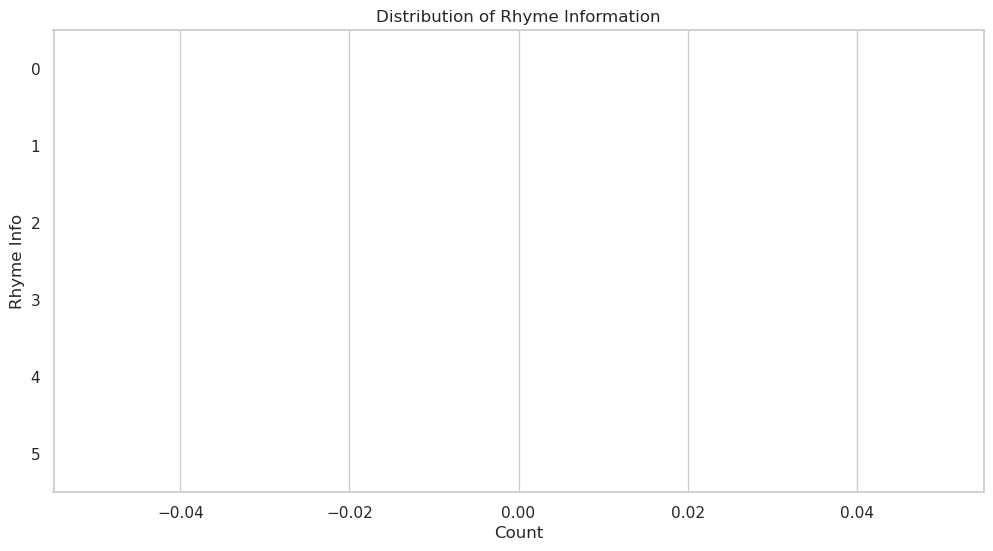

In [22]:
# Visualize distribution of rhyme_info
plt.figure(figsize=(12, 6))
sns.countplot(y='rhyme_info', data=processed_df, order=processed_df['rhyme_info'].value_counts().index)
plt.title('Distribution of Rhyme Information')
plt.xlabel('Count')
plt.ylabel('Rhyme Info')
plt.show()

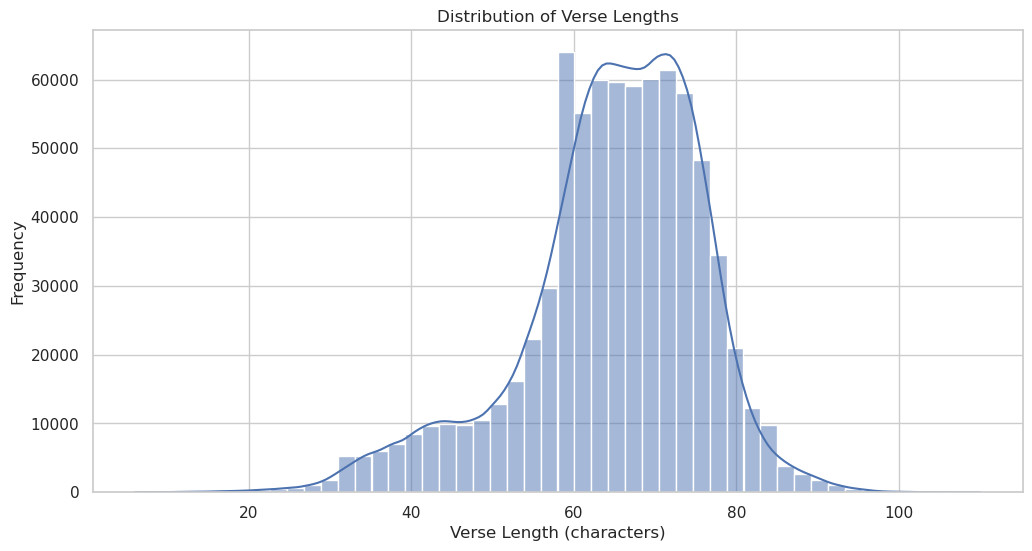

In [23]:
# Visualize verse_length
plt.figure(figsize=(12, 6))
sns.histplot(processed_df['verse_length'], bins=50, kde=True)
plt.title('Distribution of Verse Lengths')
plt.xlabel('Verse Length (characters)')
plt.ylabel('Frequency')
plt.show()

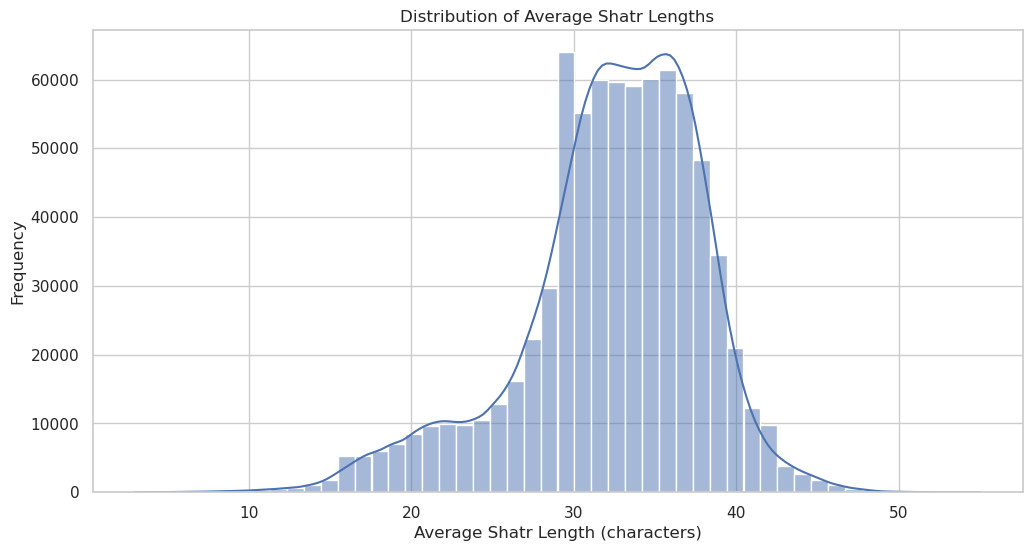

In [24]:
# Visualize average shatr length
plt.figure(figsize=(12, 6))
sns.histplot(processed_df['avg_shatr_length'], bins=50, kde=True)
plt.title('Distribution of Average Shatr Lengths')
plt.xlabel('Average Shatr Length (characters)')
plt.ylabel('Frequency')
plt.show()

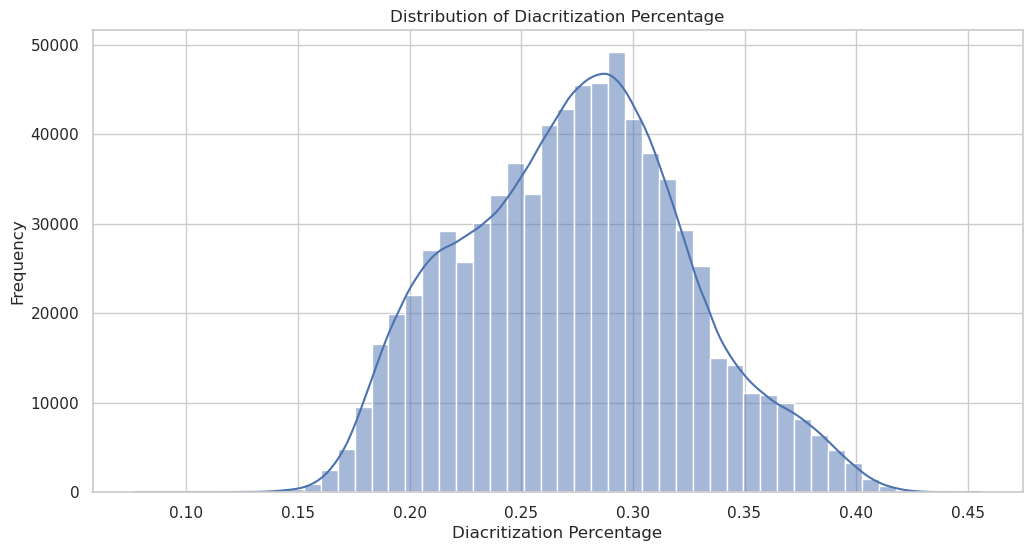

In [25]:
# Check diacritization percentage (already used for filtering, but can be visualized again)
diacritics_present = processed_df['text'].apply(lambda x: sum(1 for c in x if c in AR.tashkeel))
total_chars = processed_df['text'].apply(len)
percentage_diacritics = diacritics_present / total_chars

plt.figure(figsize=(12, 6))
sns.histplot(percentage_diacritics, bins=50, kde=True)
plt.title('Distribution of Diacritization Percentage')
plt.xlabel('Diacritization Percentage')
plt.ylabel('Frequency')
plt.show()

In [15]:
# Save processed data as CSV
print("Saving processed data...")
processed_df.to_csv(os.path.join(processed_output_dir, 'processed_data.csv'), index=False, encoding='utf-8-sig')
print(f"Processed data saved to {os.path.join(processed_output_dir, 'processed_data_0.3_only_tashkeel.csv')}")


Saving processed data...
Processed data saved to ../data/processed/processed_data_0.3_only_tashkeel.csv
